# Define Functions

##### Import Packages

In [29]:
# imports
import os
from typing import Tuple
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import pylab
import scipy.stats as stats
import torch as t
from torch.nn.functional import conv2d, pad
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import IPython
import imageio
from scipy import ndimage
from tqdm import tqdm
import pandas as pd

##### Set Device

In [2]:
# set device
device = t.device("cuda") if t.cuda.is_available() else t.device("cpu")

##### showgrid(grid, idx): 
Plot grid configuration

In [3]:
# showgrid(batch, idx): Plot grid configuration
def show_grid(batch:t.Tensor, idx=0) -> None:
  """Generate plot of the grid configuration.

  Args:
      batch (t.Tensor): (n,<dim>,<dim>) binary tensor.
      idx (int, optional): Choose grid from the batch. Defaults to 0.
  """  
  plt.imshow(batch[idx], vmin=0, vmax=1)

##### get_active_pixel_idx(grid: t.Tensor) 
Returns list of indices where pixels > 0

In [4]:
# get_active_pixel_idx(batch: t.Tensor) -> Returns list of indices where pixels > 0
def get_active_pixel_idx(batch:t.Tensor) -> t.Tensor:
  """Get a (n,3) Tensor containing the coordinates of each active pixel in the batch.

  Args:
      batch (t.Tensor): Batch of grids (n,height,width)

  Returns:
      t.Tensor: Active pixel indices
  """  
  return batch.nonzero().T

##### take_step(grid: t.Tensor, p_center: t.Tensor, dim=int)
Performs a random step in the given dimension

In [5]:
# take_step(batch: t.Tensor, p_center: t.Tensor, dim=int) -> Performs a random step in the given dimension
def take_step(batch:t.Tensor, p_center:t.Tensor, dim=-1, device=t.device("cpu")) -> t.Tensor:
  """Perform random step in the given dimension on each lattice in the batch.

  Args:
      batch (t.Tensor): Batch of lattices.
      p_center (t.Tensor): Probability of staying at current position.
      dim (int, optional): Dimension in which to perform the step (-2==y-dim, -1==x-dimension). Defaults to -1.
      device (_type_, optional): Torch computing device. Defaults to t.device("cpu").

  Returns:
      t.Tensor: Batch after the step was performed.
  """  

  act_pixel_idx = get_active_pixel_idx(batch)
  batch_size,height,width = batch.shape

  left_px = act_pixel_idx.clone()
  right_px = act_pixel_idx.clone()
  left_px[dim] -= 1
  right_px[dim] += 1
  left_px[dim][left_px[dim] < 0] = width -1
  right_px[dim][right_px[dim] == width] = 0

  p_left = t.log((1-p_center)/2)
  p_right = t.log((1-p_center)/2)

  logits = t.hstack([p_center,p_left,p_right])
  logit_tile = logits.repeat((batch_size,1))

  outcome = t.nn.functional.gumbel_softmax(logit_tile, tau=1, hard=True)

  batch[act_pixel_idx[0], act_pixel_idx[1], act_pixel_idx[2]] -= 1 - outcome[:,0]

  batch[left_px[0], left_px[1], left_px[2]] += outcome[:,1]
  batch[right_px[0], right_px[1], right_px[2]] += outcome[:,2]
  return batch

##### init_batch(n:int, dim:int)
Initialize a batch of <n> grids with size (\<dim\>,\<dim\>)

In [6]:
# init_batch(n:int, dim:int) -> Initialize a batch of <n> grids with size (<dim>,<dim>)
def init_batch(n:int, dim:int, device=t.device("cpu")):
  batch = t.zeros((n,dim,dim), device=device)
  batch[:,dim//2,dim//2] = 1
  return batch

##### create_dist_matrix(batch:t.Tensor) 
Create distance matrix with same width/height as reference batch

In [7]:
# create_dist_matrix(batch:t.Tensor) -> Create distance matrix with same width/height as reference batch
def create_dist_matrix(batch:t.Tensor, device=t.device("cpu")) -> t.Tensor:
    """Create distance matrix with same width/height as reference batch.

    Args:
        batch (t.Tensor): Reference batch.
        device (optional): Torch computing device. Defaults to t.device("cpu").

    Returns:
        t.Tensor: distance matrix.
    """    
    dist_matrix:np.ndarray = ndimage.distance_transform_edt(1-batch[0].cpu(), return_indices=False)
    dist_matrix = dist_matrix**2
    dist_matrix_t = t.from_numpy(dist_matrix).to(device)
    return dist_matrix_t

##### calc_stats(batch:t.Tensor, dist_matrix:t.Tensor)
Returns (sq_distances, avg_sq_distance, std_distance)

In [8]:
# calc_stats(batch:t.Tensor, dist_matrix:t.Tensor) -> Returns (sq_distances, avg_sq_distance, std_distance)
def calc_stats(batch:t.Tensor, dist_matrix:t.Tensor) -> Tuple[t.Tensor, t.Tensor, t.Tensor]:
  """Calculate summary statistics of the batch, I.e. Square displacements, 
  Mean Square displacement and Standard deviation of the displacements.

  Args:
      batch (t.Tensor): Batch to calculate summary statistics for.
      dist_matrix (t.Tensor): Reference distance matrix used to calculate the displacements.

  Returns:
      Tuple[t.Tensor, t.Tensor, t.Tensor]: Summary statistics.
  """  
  #print(batch.nonzero(as_tuple=True))
  #print(dist_matrix.is_cuda, batch.is_cuda)
  distances = (dist_matrix[batch.nonzero(as_tuple=True)[1:]] * batch[batch.nonzero(as_tuple=True)])
  return distances, t.mean(distances), t.std(distances)

##### Visualizations
visualize sample trajectories

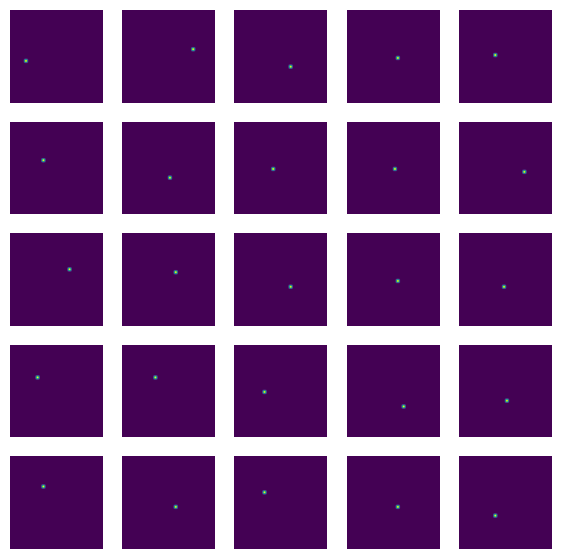

In [9]:
# visualize sample trajectories
fig, axs = plt.subplots(5,5, figsize=(7,7))

test1 = init_batch(25,32)

plots = []
for row in range(5):
  for col in range(5):
    #print(row*5+col)
    cur = axs[row,col].imshow(test1[row*5+col], vmin=0, vmax=1)
    axs[row,col].axis("off")
    plots.append(cur)

def init():
  return plots

def update(frame):
    #print(frame)
    global test1
    test1 = take_step(test1, t.tensor(0.3), dim=-1)
    test1 = take_step(test1, t.tensor(0.3), dim=-2)
    for i in range(test1.shape[0]):
      plots[i].set_data(test1[i])
    #print(plots)
    return plots

anim = animation.FuncAnimation(fig, update, init_func=init,
                             frames=50, interval=200, blit=True)
rc('animation', html='jshtml')
IPython.display.display(anim)

plot statistics for different probabilities

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


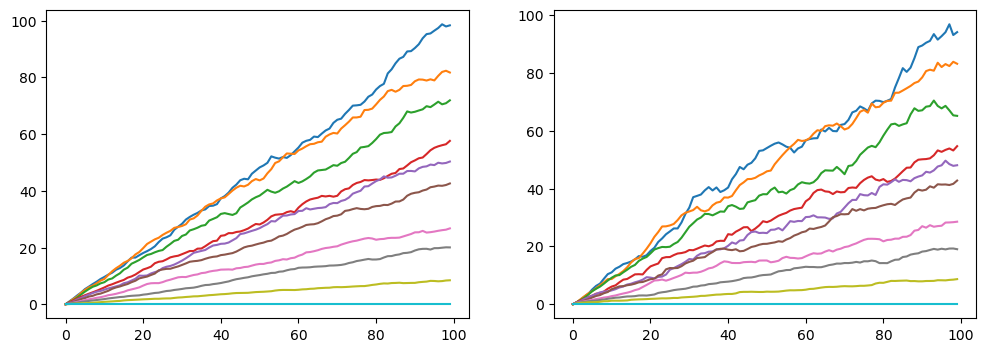

In [10]:
# plot statistics for different probabilities
p_center_vals = t.linspace(0,1,10)
ref_grid = t.zeros((1,128,128))
ref_grid[0,64,64] = 1
dist_mtx = create_dist_matrix(ref_grid)
test_batch = init_batch(200,128)
#print(calc_stats(test_batch,dist_mtx))

fig, axs = plt.subplots(1,2,figsize=(12,4))

for p_center in tqdm(p_center_vals):
  msds = []
  stds = []
  test_batch = init_batch(200,128)

  for i in range(100):
    distances, msd, std = calc_stats(test_batch,dist_mtx)
    msds.append(msd)
    stds.append(std)
    test_batch = take_step(test_batch, p_center, dim=-1)
    test_batch = take_step(test_batch, p_center, dim=-2)



  axs[0].plot(msds)
  axs[1].plot(stds)

plot histogram of square distances over 100 steps with p_center=0.5

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 55.32it/s]

tensor(45.9340, dtype=torch.float64) tensor(45.2766, dtype=torch.float64)


(array([498., 260., 121.,  65.,  28.,  17.,   6.,   2.,   2.,   1.]),
 array([  0. ,  33.3,  66.6,  99.9, 133.2, 166.5, 199.8, 233.1, 266.4,
        299.7, 333. ]),
 <BarContainer object of 10 artists>)

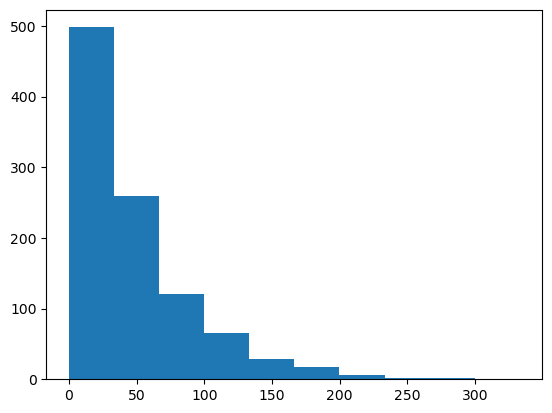

In [14]:
# plot histogram of square distances over 100 steps with p_center=0.5
test_batch = init_batch(1000,128)
ref_grid = t.zeros((1,128,128))
ref_grid[0,64,64] = 1
dist_mtx = create_dist_matrix(ref_grid)
for i in tqdm(range(100)):
    msds.append(msd)
    stds.append(std)
    test_batch = take_step(test_batch, t.tensor(0.5), dim=-1)
    test_batch = take_step(test_batch, t.tensor(0.5), dim=-2)
distances, msd, std = calc_stats(test_batch,dist_mtx)
print(msd, std)
plt.hist(distances)

plot histogram of distances over 100 steps with p_center=0.99

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 54.30it/s]

tensor(0.7510, dtype=torch.float64) tensor(1.0891, dtype=torch.float64)


(array([509., 355.,  85.,   0.,  37.,  12.,   0.,   0.,   0.,   2.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

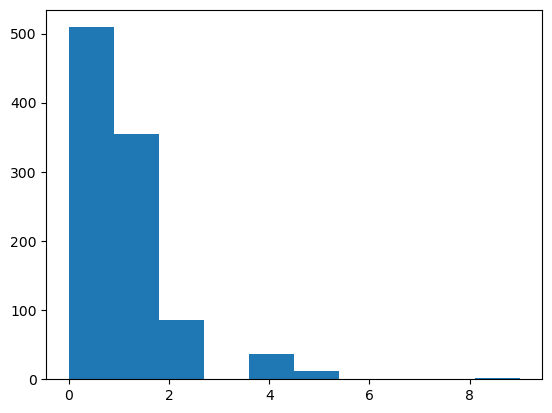

In [12]:
# plot histogram of distances over 100 steps with p_center=0.99
test_batch = init_batch(1000,128)
ref_grid = t.zeros((1,128,128))
ref_grid[0,64,64] = 1
dist_mtx = create_dist_matrix(ref_grid)
for i in tqdm(range(100)):
    msds.append(msd)
    stds.append(std)
    test_batch = take_step(test_batch, t.tensor(0.99), dim=-1)
    test_batch = take_step(test_batch, t.tensor(0.99), dim=-2)
distances, msd, std = calc_stats(test_batch,dist_mtx)
print(msd, std)
plt.hist(distances)

qqplot of the distance distribution

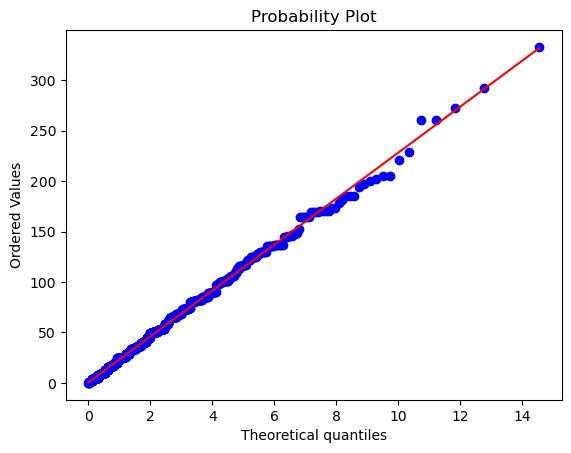

In [15]:
# qqplot of the distance distribution
stats.probplot(distances,sparams=2, dist=stats.chi2, plot=pylab)
pylab.show()

# Experiment 1: target MSD of 10 spatial units over 100 Monte Carlo steps

## Training starting from low initial movement

init training with p=0.95

In [90]:
# init training with p=0.95
p_center = t.tensor(0.95, device=device)
p_center.requires_grad_()
ref_grid = t.zeros((1,256,256))
ref_grid[0,128,128] = 1
dist_mtx = create_dist_matrix(ref_grid,device=device)

p_vals = []
grads = []
msds = []
losses = []

run training

In [91]:
# run training
for i in tqdm(range(300)):
    test_batch = init_batch(200,256,device=device)
    for i in range(100):
        test_batch = take_step(test_batch, p_center, dim=-1, device=device)
        test_batch = take_step(test_batch, p_center, dim=-2, device=device)
    distances, msd, std = calc_stats(test_batch,dist_mtx)
    loss = (msd - 10)**2
    grad = t.autograd.grad(loss,p_center)[0]
    p_center = t.clamp(p_center + 1e-6 * grad, min=0, max=1)

    p_vals.append(p_center.detach().clone().cpu().numpy())
    grads.append(grad.detach().clone().cpu().numpy())
    msds.append(msd.detach().clone().cpu().numpy())
    losses.append(loss.detach().clone().cpu().numpy())

100%|██████████| 300/300 [04:32<00:00,  1.10it/s]


plot training results

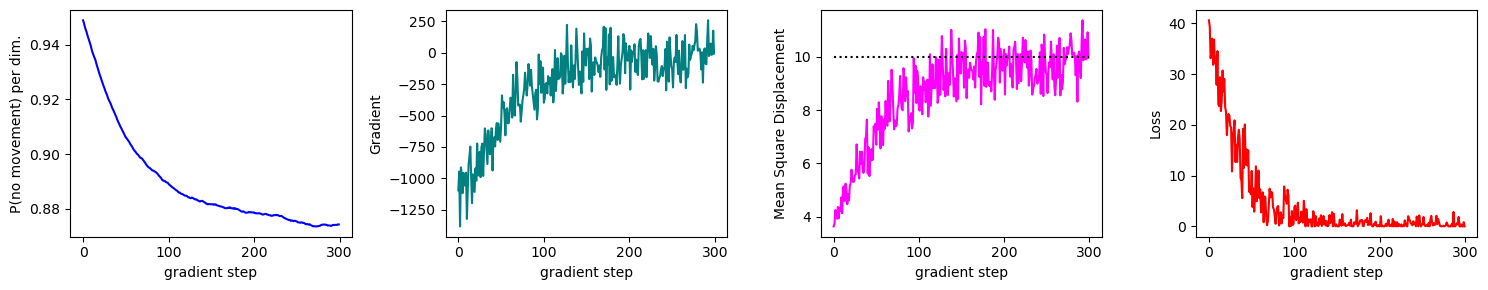

In [98]:
# plot training results
fig, axs = plt.subplots(1,4,figsize=(15,3))

axs[0].plot(p_vals, color="blue")
axs[0].set_ylabel("P(no movement) per dim.")
axs[0].set_xlabel("gradient step")
axs[1].plot(grads, color="teal")
axs[1].set_ylabel("Gradient")
axs[1].set_xlabel("gradient step")
axs[2].plot(msds, color="magenta")
axs[2].set_ylabel("Mean Square Displacement")
axs[2].set_xlabel("gradient step")
axs[2].hlines(y=10, xmin=0, xmax=300, linestyle="dotted", color="black", label="target")
axs[3].plot(losses, color="red")
axs[3].set_ylabel("Loss")
axs[3].set_xlabel("gradient step")

fig.tight_layout()

## Training starting from high initial movement

Init training with p=0.6

In [100]:
# init training with p=0.6
p_center = t.tensor(0.6, device=device)
p_center.requires_grad_()
ref_grid = t.zeros((1,256,256))
ref_grid[0,128,128] = 1
dist_mtx = create_dist_matrix(ref_grid,device=device)

p_vals = []
grads = []
msds = []
losses = []

run training

In [101]:
# run training
for i in tqdm(range(300)):
    test_batch = init_batch(200,256,device=device)
    for i in range(100):
        test_batch = take_step(test_batch, p_center, dim=-1, device=device)
        test_batch = take_step(test_batch, p_center, dim=-2, device=device)
    distances, msd, std = calc_stats(test_batch,dist_mtx)
    loss = (msd - 10)**2
    grad = t.autograd.grad(loss,p_center)[0]
    p_center = t.clamp(p_center + 1e-6 * grad, min=0, max=1)

    p_vals.append(p_center .detach().clone().cpu().numpy())
    grads.append(grad.detach().clone().cpu().numpy())
    msds.append(msd.detach().clone().cpu().numpy())
    losses.append(loss.detach().clone().cpu().numpy())

100%|██████████| 300/300 [04:33<00:00,  1.10it/s]


plot results

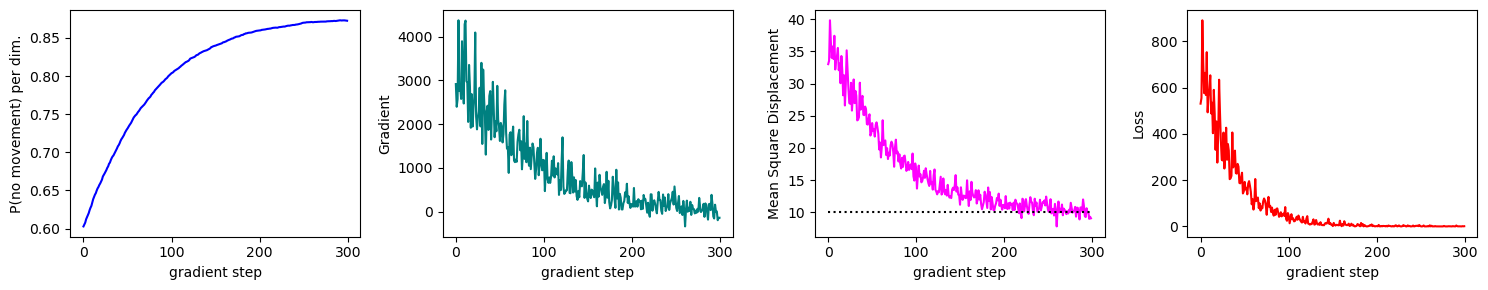

In [102]:
# plot results
fig, axs = plt.subplots(1,4,figsize=(15,3))

axs[0].plot(p_vals, color="blue")
axs[0].set_ylabel("P(no movement) per dim.")
axs[0].set_xlabel("gradient step")
axs[1].plot(grads, color="teal")
axs[1].set_ylabel("Gradient")
axs[1].set_xlabel("gradient step")
axs[2].plot(msds, color="magenta")
axs[2].set_ylabel("Mean Square Displacement")
axs[2].set_xlabel("gradient step")
axs[2].hlines(y=10, xmin=0, xmax=300, linestyle="dotted", color="black", label="target")
axs[3].plot(losses, color="red")
axs[3].set_ylabel("Loss")
axs[3].set_xlabel("gradient step")

fig.tight_layout()

## Testing

visualize sample trajectories

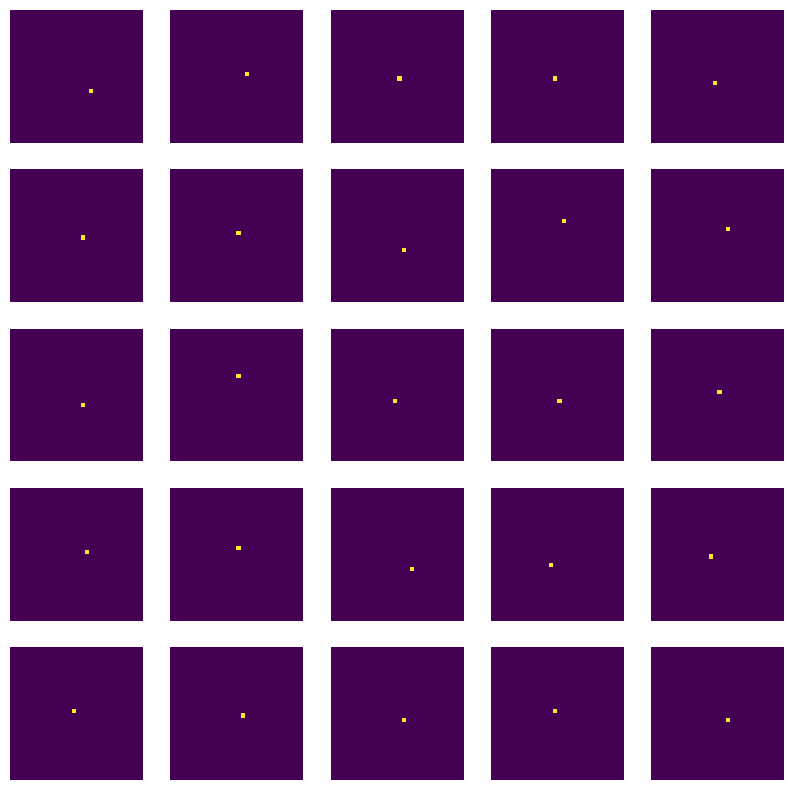

In [86]:
# visualize sample trajectories
fig, axs = plt.subplots(5,5, figsize=(10,10))

test1 = init_batch(25,32)

plots = []
for row in range(5):
  for col in range(5):
    #print(row*5+col)
    cur = axs[row,col].imshow(test1[row*5+col], vmin=0, vmax=1)
    axs[row,col].axis("off")
    plots.append(cur)

def init():
  return plots

def update(frame):
    #print(frame)
    global test1
    test1 = take_step(test1, t.tensor(0.88), dim=-1)
    test1 = take_step(test1, t.tensor(0.88), dim=-2)
    for i in range(test1.shape[0]):
      plots[i].set_data(test1[i])
    #print(plots)
    return plots

anim = animation.FuncAnimation(fig, update, init_func=init,
                             frames=50, interval=200, blit=True)
rc('animation', html='jshtml')
IPython.display.display(anim)

Plot histogram of square distances over 100 steps with the optimized p=0.88

100%|██████████| 100/100 [00:01<00:00, 57.06it/s]

tensor(10.1270, dtype=torch.float64) tensor(10.1530, dtype=torch.float64)


(array([543., 244., 128.,  43.,  30.,   8.,   2.,   0.,   0.,   2.]),
 array([ 0. ,  8.5, 17. , 25.5, 34. , 42.5, 51. , 59.5, 68. , 76.5, 85. ]),
 <BarContainer object of 10 artists>)

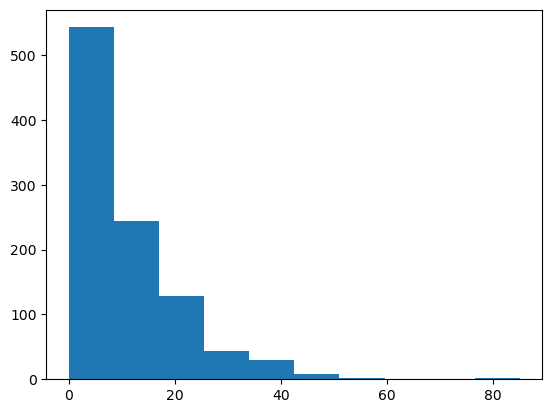

In [87]:
# plot histogram of distances over 100 steps with p_center=0.88
test_batch = init_batch(1000,128)
ref_grid = t.zeros((1,128,128))
ref_grid[0,64,64] = 1
dist_mtx = create_dist_matrix(ref_grid)
for i in tqdm(range(100)):
    msds.append(msd)
    stds.append(std)
    test_batch = take_step(test_batch, t.tensor(0.88), dim=-1)
    test_batch = take_step(test_batch, t.tensor(0.88), dim=-2)
distances, msd, std = calc_stats(test_batch,dist_mtx)
print(msd, std)
plt.hist(distances)

qqplot of the distance distribution

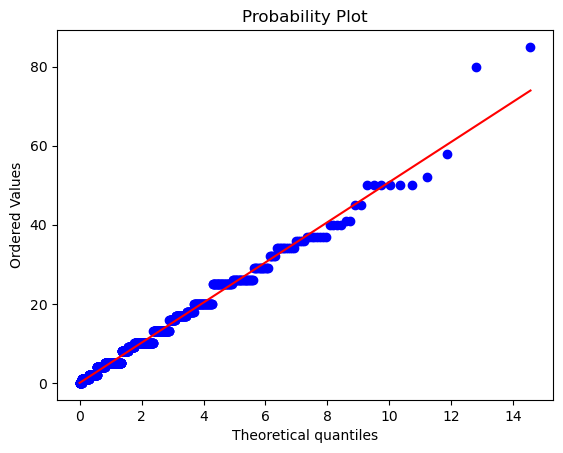

In [88]:
# qqplot of the distance distribution
stats.probplot(distances,sparams=2, dist=stats.chi2, plot=pylab)
pylab.show()

# Experiment 2: 800 Monte Carlo steps, Target MSD of 45

plot histogram of square distances over 800 MCS with p=0.93

  0%|          | 0/800 [00:00<?, ?it/s]100%|██████████| 800/800 [00:11<00:00, 68.25it/s]

tensor(45.4310, dtype=torch.float64) tensor(46.7218, dtype=torch.float64)


(array([495., 243., 134.,  72.,  26.,  11.,   6.,   7.,   2.,   4.]),
 array([  0. ,  31.7,  63.4,  95.1, 126.8, 158.5, 190.2, 221.9, 253.6,
        285.3, 317. ]),
 <BarContainer object of 10 artists>)

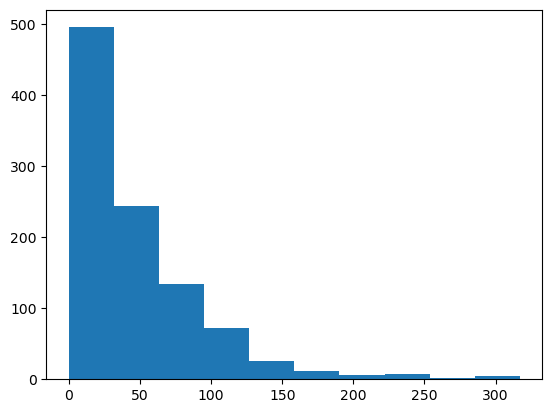

In [107]:
# plot histogram of distances over 800 steps with p_center=0.93
test_batch = init_batch(1000,128)
ref_grid = t.zeros((1,128,128))
ref_grid[0,64,64] = 1
dist_mtx = create_dist_matrix(ref_grid)
for i in tqdm(range(800)):
    msds.append(msd)
    stds.append(std)
    test_batch = take_step(test_batch, t.tensor(0.93), dim=-1)
    test_batch = take_step(test_batch, t.tensor(0.93), dim=-2)
distances, msd, std = calc_stats(test_batch,dist_mtx)
print(msd, std)
plt.hist(distances)

init training

In [113]:
# init training
p_center = t.tensor(0.995, device=device)
p_center.requires_grad_()
ref_grid = t.zeros((1,256,256))
ref_grid[0,128,128] = 1
dist_mtx = create_dist_matrix(ref_grid,device=device)

p_vals = []
grads = []
msds = []
losses = []

run training

In [117]:
# run training
for i in tqdm(range(300)):
    test_batch = init_batch(200,256,device=device)
    for i in range(800):
        test_batch = take_step(test_batch, p_center, dim=-1, device=device)
        test_batch = take_step(test_batch, p_center, dim=-2, device=device)
    distances, msd, std = calc_stats(test_batch,dist_mtx)
    loss = (msd - 45)**2
    grad = t.autograd.grad(loss,p_center)[0]
    p_center = t.clamp(p_center + 1e-6 * grad, min=0, max=1)

    p_vals.append(p_center .detach().clone().cpu().numpy())
    grads.append(grad.detach().clone().cpu().numpy())
    msds.append(msd.detach().clone().cpu().numpy())
    losses.append(loss.detach().clone().cpu().numpy())

100%|██████████| 300/300 [36:32<00:00,  7.31s/it]


plot results

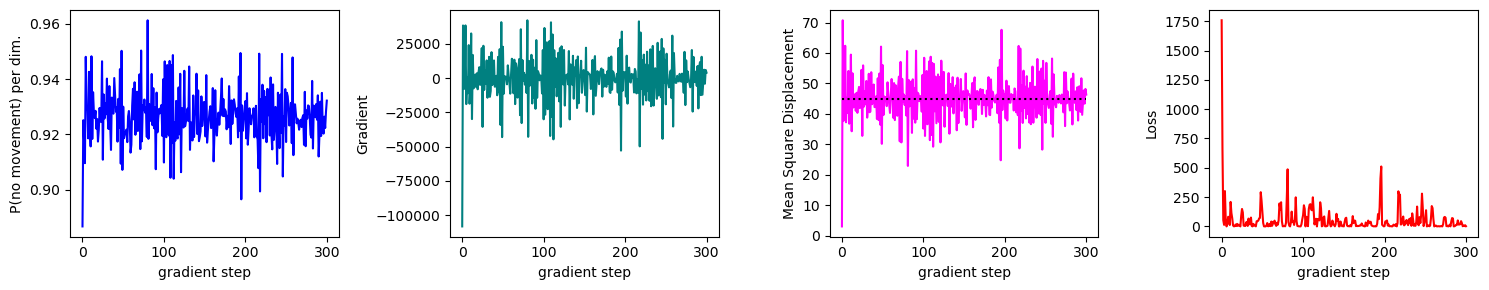

In [119]:
# plot results
fig, axs = plt.subplots(1,4,figsize=(15,3))

axs[0].plot(p_vals, color="blue")
axs[0].set_ylabel("P(no movement) per dim.")
axs[0].set_xlabel("gradient step")
axs[1].plot(grads, color="teal")
axs[1].set_ylabel("Gradient")
axs[1].set_xlabel("gradient step")
axs[2].plot(msds, color="magenta")
axs[2].set_ylabel("Mean Square Displacement")
axs[2].set_xlabel("gradient step")
axs[2].hlines(y=45, xmin=0, xmax=300, linestyle="dotted", color="black", label="target")
axs[3].plot(losses, color="red")
axs[3].set_ylabel("Loss")
axs[3].set_xlabel("gradient step")

fig.tight_layout()

# Experiment 3: Listeria data

## LM-37 data processing

In [17]:
df_37 = pd.read_csv(
    "bacteria-37.csv",
    header=1,
    usecols= [
        "Position X",
        "Position Y",
        "Position Z",
        "Time",
        "TrackID",
        "ID"
    ]
)

In [18]:
sq_displacements_37 = []
for trackID in pd.unique(df_37["TrackID"]):
    track_data = df_37[df_37["TrackID"] == trackID].sort_values(by="Time")
    sq_displacements_track = []
    og_x = track_data["Position X"].iloc[0]
    og_y = track_data["Position Y"].iloc[0]
    for index, timepoint in track_data[1:].iterrows():
        sq_displacement_x = (og_x - timepoint["Position X"])**2
        sq_displacement_y = (og_y - timepoint["Position Y"])**2
        sq_displacements_track.append({
            "trackID": trackID,
            "t": timepoint["Time"],
            "sq_displacement_x": sq_displacement_x,
            "sq_displacement_y": sq_displacement_y
        })
    sq_displacements_37.append(pd.DataFrame(sq_displacements_track))
df_sq_displacements_37 =  pd.concat(sq_displacements_37)
display(df_sq_displacements_37.head())   

,trackID,t,sq_displacement_x,sq_displacement_y
0,1000000008,2.0,0.000016,0.0
1,1000000008,3.0,0.000196,0.0
2,1000000008,4.0,0.000576,0.0
3,1000000008,5.0,0.000001,0.0
4,1000000008,6.0,0.000025,0.0


In [20]:
MSDs_37 = []
for timestamp in pd.unique(df_sq_displacements_37["t"]):
    data_slice = df_sq_displacements_37[df_sq_displacements_37["t"] == timestamp]
    mean_sq_x_dev = np.mean(data_slice["sq_displacement_x"].to_numpy())
    mean_sq_y_dev = np.mean(data_slice["sq_displacement_y"].to_numpy())
    MSDs_37.append(mean_sq_x_dev + mean_sq_y_dev)

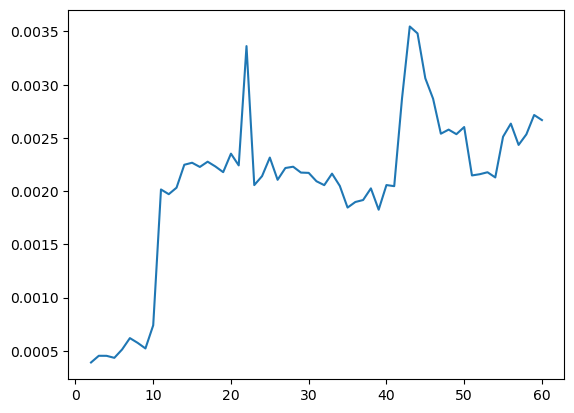

In [22]:
plt.plot(pd.unique(df_sq_displacements_37["t"]), MSDs_37)

## LM-RT data processing

In [23]:
df_rt = pd.read_csv(
    "bacteria-RT.csv",
    header=1,
    usecols= [
        "Position X",
        "Position Y",
        "Position Z",
        "Time",
        "TrackID",
        "ID"
    ]
)

In [25]:
sq_displacements_rt = []
for trackID in pd.unique(df_rt["TrackID"]):
    track_data = df_rt[df_rt["TrackID"] == trackID].sort_values(by="Time")
    sq_displacements_track = []
    og_x = track_data["Position X"].iloc[0]
    og_y = track_data["Position Y"].iloc[0]
    for index, timepoint in track_data[1:].iterrows():
        sq_displacement_x = (og_x - timepoint["Position X"])**2
        sq_displacement_y = (og_y - timepoint["Position Y"])**2
        sq_displacements_track.append({
            "trackID": trackID,
            "t": timepoint["Time"],
            "sq_displacement_x": sq_displacement_x,
            "sq_displacement_y": sq_displacement_y
        })
    sq_displacements_rt.append(pd.DataFrame(sq_displacements_track))
df_sq_displacements_rt =  pd.concat(sq_displacements_rt)
display(df_sq_displacements_rt.head())   

,trackID,t,sq_displacement_x,sq_displacement_y
0,1000000007,2.0,0.005329,0.0
1,1000000007,3.0,0.220900,0.0
2,1000000007,4.0,0.157609,0.0
3,1000000007,5.0,0.147456,0.0
4,1000000007,6.0,0.127449,0.0


In [26]:
MSDs_rt = []
for timestamp in pd.unique(df_sq_displacements_rt["t"]):
    data_slice = df_sq_displacements_rt[df_sq_displacements_rt["t"] == timestamp]
    mean_sq_x_dev = np.mean(data_slice["sq_displacement_x"].to_numpy())
    mean_sq_y_dev = np.mean(data_slice["sq_displacement_y"].to_numpy())
    MSDs_rt.append(mean_sq_x_dev + mean_sq_y_dev)

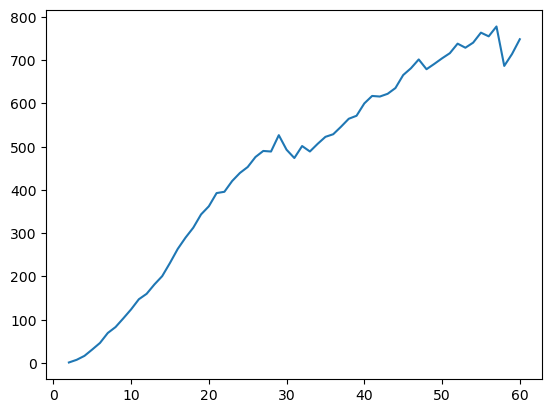

In [27]:
plt.plot(pd.unique(df_sq_displacements_37["t"]), MSDs_rt)

## LM-RT-filtered data processing

In [31]:
data_folder = "./csv"
track_paths = os.listdir(data_folder)

frames = []
for path in track_paths:
    df = pd.read_csv(f"{data_folder}/{path}", index_col=0)
    df["trackID"] = path.split(" ")[-2]
    #print(df.head())
    frames.append(df)

df_filtered = pd.concat(frames, ignore_index=True)
display(df_filtered.head())

,t,x,y,trackID
0,0.25,274.245,261.445,1000000032
1,0.50,274.232,261.450,1000000032
2,0.75,274.237,261.449,1000000032
3,1.00,274.224,261.416,1000000032
4,1.25,274.225,261.369,1000000032


In [32]:
sq_displacements_filtered = []
for trackID in pd.unique(df_filtered["trackID"]):
    track_data = df_filtered[df_filtered["trackID"] == trackID].sort_values(by="t")
    sq_displacements_track = []
    #print(track_data.head())
    #print(track_data["x"].iloc[0])
    og_x = track_data["x"].iloc[0]
    og_y = track_data["y"].iloc[0]
    for index, timepoint in track_data[1:].iterrows():
        sq_displacement_x = (og_x - timepoint["x"])**2
        sq_displacement_y = (og_y - timepoint["y"])**2
        sq_displacements_track.append({
            "trackID": trackID,
            "t": timepoint["t"],
            "deviation_x": sq_displacement_x,
            "deviation_y": sq_displacement_y
        })
    sq_displacements_filtered.append(pd.DataFrame(sq_displacements_track))
df_sq_displacements_filtered =  pd.concat(sq_displacements_filtered)
display(df_sq_displacements_filtered.head())   

,trackID,t,deviation_x,deviation_y
0,1000000032,0.50,0.000169,0.000025
1,1000000032,0.75,0.000064,0.000016
2,1000000032,1.00,0.000441,0.000841
3,1000000032,1.25,0.000400,0.005776
4,1000000032,1.50,0.017689,0.000361


In [36]:
MSDs_filtered = []
for timestamp in pd.unique(df_sq_displacements_filtered["t"]):
    data_slice = df_sq_displacements_filtered[df_sq_displacements_filtered["t"] == timestamp]
    mean_sq_x_dev = np.mean(data_slice["deviation_x"].to_numpy())
    mean_sq_y_dev = np.mean(data_slice["deviation_y"].to_numpy())
    MSDs_filtered.append(mean_sq_x_dev + mean_sq_y_dev)

(-30.0, 800.0)

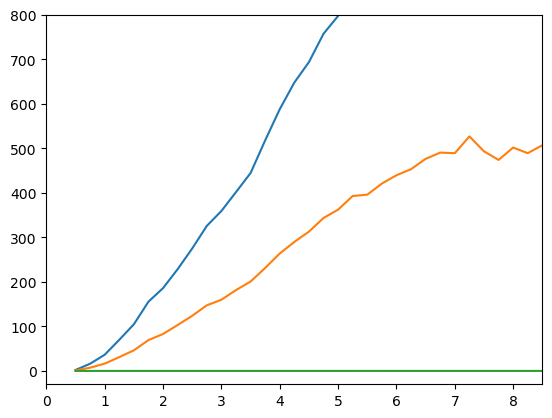

In [46]:
plt.plot(pd.unique(df_sq_displacements_filtered["t"]), MSDs_filtered)
plt.plot(pd.unique(df_sq_displacements_filtered["t"]), MSDs_rt)
plt.plot(pd.unique(df_sq_displacements_filtered["t"]), MSDs_37)
plt.xlim(0,8.5)
plt.ylim(-30,800)

In [47]:
MSDs_filtered

[2.1214383838383726,
 16.16651475247522,
 36.36531934134614,
 69.88281371904758,
 104.76196367942578,
 155.49427532093023,
 185.98230210747658,
 228.4922145321101,
 275.03647594520544,
 325.68220101801785,
 359.1277898837209,
 401.59474704128434,
 444.41984792626715,
 517.7228298130841,
 587.7785285093457,
 647.6206195138889,
 693.5548973242007,
 757.1270429954543,
 797.2454724753361,
 860.7379165829598,
 869.0061122690583,
 911.3952395336321,
 947.5577301651784,
 968.2449196902655,
 1024.3624740666667,
 1050.4650798266666,
 1057.8084635429864,
 1128.9409521165917,
 1056.3853668274337,
 1014.8384849513275,
 1057.3823130987123,
 1032.8487558051945,
 1055.0442782245761,
 1105.1867231125539,
 1115.436409300429,
 1164.1354011179037,
 1205.782458852174,
 1223.9852964757708,
 1274.789586592105,
 1308.4575616304346,
 1299.8853915411255,
 1315.1666084051722,
 1339.8247244743588,
 1409.1745221379308,
 1427.907507754237,
 1487.1569213376622,
 1428.8689547264953,
 1481.5392053097344,
 1522.762394

## Test: Each datapoint is 100 MCS

In [79]:
# init training
p_center = t.tensor(0.4, device=device)
p_center.requires_grad_()
ref_grid = t.zeros((1,512,512))
ref_grid[0,256,256] = 1
dist_mtx = create_dist_matrix(ref_grid,device=device)

p_vals = []
grads = []
msds = []
losses = []

In [ ]:
# run training
for i in tqdm(range(100)):
    test_batch = init_batch(200,512,device=device)
    total_loss = 0
    msds_cur = []
    for i in range(1000):
        test_batch = take_step(test_batch, p_center, dim=-1, device=device)
        test_batch = take_step(test_batch, p_center, dim=-2, device=device)
        if (i+1) % 100 == 0 and i > 0:
            target = MSDs_filtered[(i+1) // 100]
            distances, msd, std = calc_stats(test_batch,dist_mtx)
            msds_cur.append(msd.detach().clone().cpu().numpy())
            total_loss += (msd - target)**2
    total_loss /= 100
    grad = t.autograd.grad(total_loss,p_center)[0]
    p_center = t.clamp(p_center + 1e-5 * grad, min=0, max=1)

    print(f"loss={total_loss}, grad={grad}, p={p_center}, msds={msds_cur}")
    p_vals.append(p_center .detach().clone().cpu().numpy())
    grads.append(grad.detach().clone().cpu().numpy())
    msds.append(msds_cur)
    losses.append(total_loss.detach().clone().cpu().numpy())

In [88]:
test_batch = init_batch(200,512,device=device)
msds_test = []
for i in tqdm(range(10_000)):
        test_batch = take_step(test_batch, p_center, dim=-1, device=device)
        test_batch = take_step(test_batch, p_center, dim=-2, device=device)
        if (i+1) % 100 == 0 and i > 0:
            distances, msd, std = calc_stats(test_batch,dist_mtx)
            msds_test.append(msd.detach().clone().cpu().numpy())

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:55<00:00, 179.87it/s]


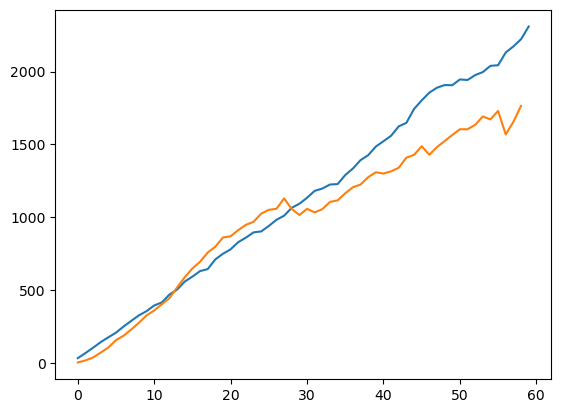

In [92]:
plt.plot(msds_test[:60])
plt.plot(MSDs_filtered)

# Exploratory Analysis

In [93]:
def calc_analytical_grad(p:float,n:int,y:float) -> float:
    """Calculate the analytical gradient w.r.t. <p> of the MSE between Mean Square displacement of a
      random walk with two degrees of freedom and a target MSD. 
      The MSD is given by:
         2*(1-p)*n
      The loss is defined as:
         (2*(1-p)*n - y)**2
      The gradient function w.r.t. <p>:
         -4*n*(-2*n*(-1 + p) - y)

    Args:
        p (float): The probability of staying in place.
        n (int): The number of Monte-Carlo steps.
        y (float): The target MSD.

    Returns:
        float: Gradient value.
    """
    return -4*n*(-2*n*(p-1) - y)

In [97]:
import numpy as np
p_vals = np.linspace(0,1,1000)
y = 10
n = 100

grads = []
for p_val in p_vals:
    grad = calc_analytical_grad(p_val, n, y)
    grads.append(grad)

Text(0, 0.5, 'gradient')

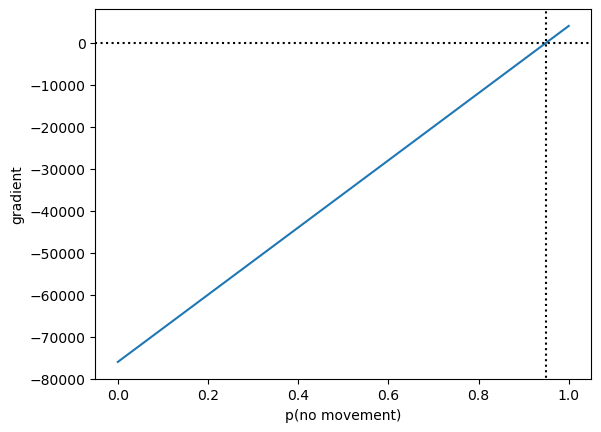

In [110]:
plt.plot(p_vals, grads)
plt.axvline(x=0.95, ymin=np.min(grads), ymax=np.max(grads), color="black", linestyle="dotted")
plt.axhline(y=0, xmin=0, xmax=1, color="black", linestyle="dotted")
plt.xlabel("p(no movement)")
plt.ylabel("gradient")